In [18]:
import os
import json

# Create an empty list to store the dictionaries
json_data_list = []

# Directory where your JSON files are located
json_files_directory = '../../DataEng/datalake/bronze'

# Loop through each JSON file in the directory
for filename in os.listdir(json_files_directory):
    if filename.startswith('data_') and filename.endswith('.json'):
        # Construct the full path to the JSON file
        file_path = os.path.join(json_files_directory, filename)

        # Open and read the JSON file
        with open(file_path, 'r') as json_file:
            # Load the JSON data into a dictionary
            json_data = json.load(json_file)

            # Create a new dictionary to hold both the file name and JSON data
            json_with_filename = {
                'filename': filename,  # Save the file name
                'data': json_data     # Save the JSON data
            }

            # Append the dictionary to the list
            json_data_list.append(json_with_filename)

# Now, json_data_list contains a list of dictionaries, where each dictionary has a 'filename' key
# with the name of the JSON file and a 'data' key with the JSON data from that file for files starting with 'data_'.


import pandas as pd


# Create a DataFrame
df = pd.DataFrame(json_data_list)

# If you want to flatten the 'data' dictionary into separate columns:
df = pd.concat([df.drop(['data'], axis=1), df['data'].apply(pd.Series)], axis=1)

# Now, df contains your data in a Pandas DataFrame format
df

# Extract and transform the 'filename' column into a timestamp column
df['timestamp'] = pd.to_datetime(df['filename'].str.extract(r'data_(\d{14})\.json')[0], format='%Y%m%d%H%M%S')

# Drop the 'filename' column if no longer needed
df = df.drop('filename', axis=1)

# Now, df contains a 'timestamp' column extracted from the 'filename'
df.head()

#save df to csv on the silver layer name ghanor
df.drop(columns=['targetAmount', 'targetDate']).to_csv('../../DataEng/datalake/silver/ghanor.csv', index=False)

In [19]:
#read ghanor file on ../../DataEng/datalake/silver/ghanor.csv
import pandas as pd

df = pd.read_csv('../../DataEng/datalake/silver/ghanor.csv', sep=',')
df.head()

,raisedAmount,supporters,timestamp
0,4731772.0,4495,2023-10-08 21:07:04
1,4847103.0,4650,2023-10-08 22:24:04
2,4830483.0,4630,2023-10-08 22:19:03
3,4724127.0,4484,2023-10-08 20:56:04
4,5131208.0,5015,2023-10-09 21:46:04


In [20]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

#order by timestamp
df = df.sort_values(by=['timestamp'], ascending=False)
df.head(10)

,raisedAmount,supporters,timestamp
611,5131208.0,5015,2023-10-09 22:00:04
623,5131208.0,5015,2023-10-09 21:59:04
4,5131208.0,5015,2023-10-09 21:46:04
672,5130741.0,5014,2023-10-09 21:43:04
553,5130452.0,5013,2023-10-09 21:42:04
14,5130203.0,5012,2023-10-09 21:40:04
363,5130203.0,5012,2023-10-09 21:39:05
505,5130203.0,5012,2023-10-09 21:38:04
437,5130203.0,5012,2023-10-09 21:37:04
457,5130203.0,5012,2023-10-09 21:36:04


In [21]:
# analyze the data only from the last day column timestamp


#transform column timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
last_day = df['timestamp'].max().date()

last_day

#group data from last day

df_last_day = df[df['timestamp'].dt.date == last_day]
df_last_day

,raisedAmount,supporters,timestamp
611,5131208.0,5015,2023-10-09 22:00:04
623,5131208.0,5015,2023-10-09 21:59:04
4,5131208.0,5015,2023-10-09 21:46:04
672,5130741.0,5014,2023-10-09 21:43:04
553,5130452.0,5013,2023-10-09 21:42:04
...,...,...,...
784,5037869.0,4877,2023-10-09 00:05:04
566,5033969.0,4875,2023-10-09 00:03:03
215,5032019.0,4874,2023-10-09 00:02:03
244,5031569.0,4873,2023-10-09 00:01:04


In [26]:
#create columns with diff raisedAmount and first raisedAmount
df_last_day['diff_raisedAmount'] = df_last_day['raisedAmount'] - df_last_day['raisedAmount'].iloc[-1]


C:\Users\Igor\AppData\Local\Temp\ipykernel_18356\3429334334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_day['diff_raisedAmount'] = df_last_day['raisedAmount'] - df_last_day['raisedAmount'].iloc[-1]


<Axes: xlabel='timestamp'>

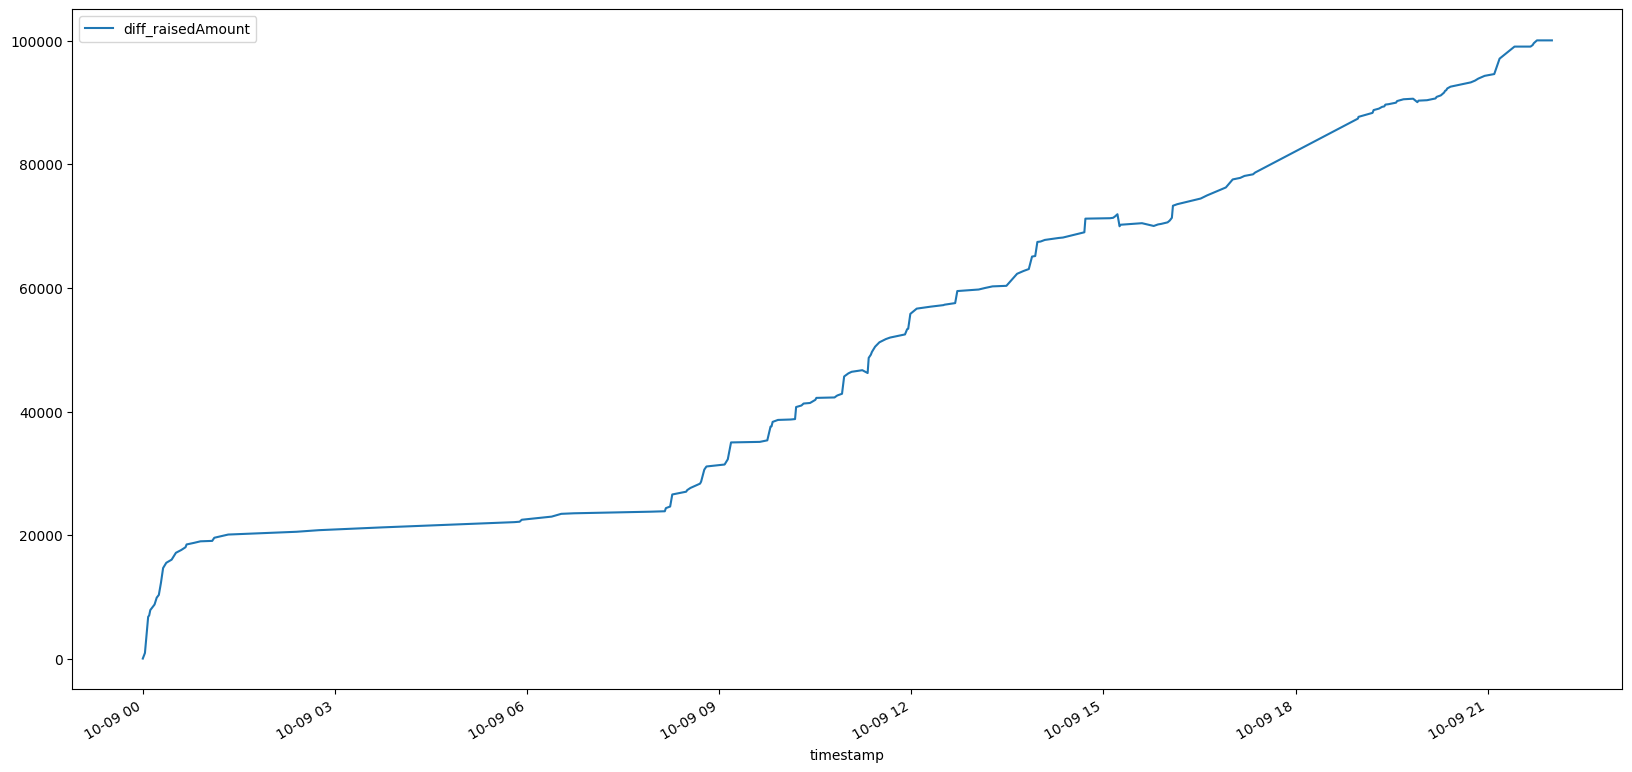

In [27]:
df_last_day.plot(x='timestamp', y='diff_raisedAmount', kind='line', figsize=(20, 10))